In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import os
from shapely.geometry import mapping, box
from rasterio.mask import mask
from rasterio.enums import Resampling

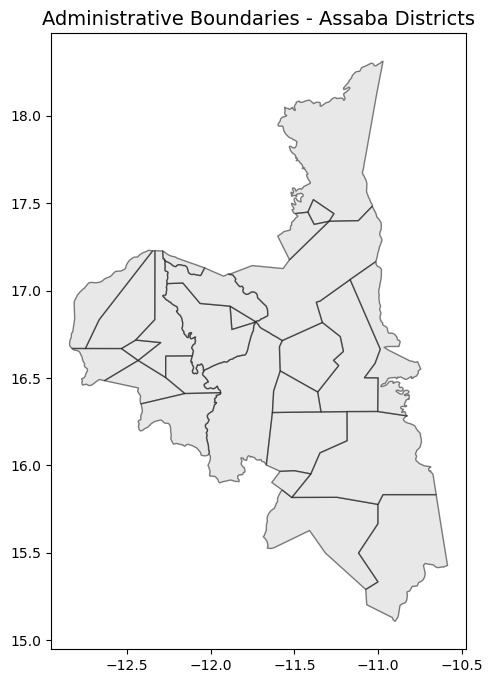

In [2]:
admin_shapefile = "Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"
admin_gdf = gpd.read_file(admin_shapefile)

# Plot the administrative boundaries
fig, ax = plt.subplots(figsize=(10, 8))
admin_gdf.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5)
ax.set_title("Administrative Boundaries - Assaba Districts", fontsize=14)
plt.show()

In [3]:
admin_gdf.columns

Index(['FID_1', 'ADM3_EN', 'ADM3_PCODE', 'ADM3_REF', 'ADM2_EN', 'ADM2_PCODE',
       'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn',
       'validTo', 'Shape_Leng', 'Shape_Area', 'AREA_SQKM', 'geometry'],
      dtype='object')

In [4]:
print(admin_gdf['ADM3_EN'])

0       El Ghabra
1          Guerou
2       Barkeiwel
3         Legrane
4            Sani
5         Daghveg
6     Bou Lahrath
7           Hamed
8         Gueller
9       El Melgue
10      El Ghaira
11        Lebheir
12    Oudeiy Jrid
13         Tenaha
14         Lavtah
15          Kiffa
16        Blajmil
17     R’Dheidhie
18         Kamour
19       Boumdeid
20     Kouroudjel
21      Nouamlein
22       Laweissi
23      Hseiy Tin
24      Kankoussa
25        Aghorat
Name: ADM3_EN, dtype: object


In [5]:
test = "Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif"
# check for no water bodies

with rasterio.open(test) as src:
    # Read the dataset from the beginning
    modis_data = src.read(1)
    # Get the metadata of the dataset
    modis_meta = src.meta
    
    
print(modis_data)

[[-128 -128 -128 ... -128 -128 -128]
 [-128 -128 -128 ... -128 -128 -128]
 [-128 -128 -128 ... -128 -128 -128]
 ...
 [-128 -128 -128 ... -128 -128 -128]
 [-128 -128 -128 ... -128 -128 -128]
 [-128 -128 -128 ... -128 -128 -128]]


In [6]:
# Define file paths
modis_dataset_path = "Datasets_Hackathon/Modis_Land_Cover_Data/"
shapefile_path = "Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"  # Update this if needed

# Load the district boundaries
admin_gdf = gpd.read_file(shapefile_path)

# Dictionary to store processed data
all_years_data = []

# Process data for each year from 2010 to 2023
years = list(range(2010, 2024))

for year in years:
    tif_file = f"{modis_dataset_path}{year}LCT.tif"
    
    # Check if the file exists before processing
    if not os.path.exists(tif_file):
        print(f"File {tif_file} not found, skipping...")
        continue

    # Open the MODIS raster to get its CRS and bounds
    with rasterio.open(tif_file) as dataset:
        raster_crs = dataset.crs
        raster_bounds = box(*dataset.bounds)

        # Reproject shapefile if necessary
        if admin_gdf.crs != raster_crs:
            admin_gdf = admin_gdf.to_crs(raster_crs)

        # Filter districts that overlap the raster extent
        admin_gdf_filtered = admin_gdf[admin_gdf.intersects(raster_bounds)]

        if admin_gdf_filtered.empty:
            print(f"No districts overlap the MODIS raster for {year}. Check dataset extents.")
            continue

        # Process each district separately
        for idx, row in admin_gdf_filtered.iterrows():
            district_name = row["ADM3_EN"]  # District name
            district_geom = [mapping(row["geometry"])]  # Convert to geometry format

            try:
                # Mask the raster to the district
                out_image, _ = mask(dataset, district_geom, crop=True)
                data = out_image[0].flatten()  # Convert to 1D array

                # Count occurrences of each land cover type
                unique, counts = np.unique(data[data > 0], return_counts=True)

                # Convert to DataFrame and map labels
                temp_df = pd.DataFrame({
                    "Year": year,
                    "District": district_name,
                    "LandCoverClass": unique,
                    "PixelCount": counts
                })

                # Normalize pixel counts (convert to percentage)
                total_pixels = temp_df["PixelCount"].sum()
                temp_df["Percentage"] = (temp_df["PixelCount"] / total_pixels) * 100

                # Append results
                all_years_data.append(temp_df)

            except Exception as e:
                print(f"Error processing district {district_name} for year {year}: {e}")

# Combine all years' data into a single DataFrame
district_landcover_df = pd.concat(all_years_data, ignore_index=True)

In [7]:
modis_labels = {
    0: "Water Bodies",
    1: "Evergreen Needleleaf Forests",
    2: "Evergreen Broadleaf Forests",
    3: "Deciduous Needleleaf Forests",
    4: "Deciduous Broadleaf Forests",
    5: "Mixed Forests",
    6: "Closed Shrublands",
    7: "Open Shrublands",
    8: "Woody Savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent Wetlands",
    12: "Croplands",
    13: "Urban and Built-up Lands",
    14: "Cropland/Natural Vegetation Mosaics",
    15: "Permanent Snow and Ice",
    16: "Barren or Sparsely Vegetated",
    17: "Water Bodies (Collection 6)"
}

district_landcover_df["LandCoverLabel"] = district_landcover_df["LandCoverClass"].map(modis_labels)  # Map class to labels

In [8]:
district_landcover_df.describe()

,Year,LandCoverClass,PixelCount,Percentage
count,1345.000000,1345.000000,1345.000000,1345.000000
mean,2016.559108,72.171004,3389.099628,27.063197
std,3.959387,106.006270,4820.745612,24.857153
min,2010.000000,7.000000,1.000000,0.003969
25%,2013.000000,10.000000,79.000000,0.730159
50%,2017.000000,10.000000,1063.000000,26.794306
75%,2020.000000,255.000000,5369.000000,47.460458
max,2023.000000,255.000000,23159.000000,99.986307


In [9]:
district_landcover_df.head(30)

,Year,District,LandCoverClass,PixelCount,Percentage,LandCoverLabel
0,2010,El Ghabra,7,19,0.727691,Open Shrublands
1,2010,El Ghabra,10,1736,66.487936,Grasslands
2,2010,El Ghabra,16,856,32.784374,Barren or Sparsely Vegetated
3,2010,Guerou,10,517,94.000000,Grasslands
4,2010,Guerou,16,33,6.000000,Barren or Sparsely Vegetated
5,2010,Barkeiwel,7,3,0.390117,Open Shrublands
6,2010,Barkeiwel,10,298,38.751625,Grasslands
7,2010,Barkeiwel,16,468,60.858257,Barren or Sparsely Vegetated
8,2010,Legrane,7,196,1.316939,Open Shrublands
9,2010,Legrane,10,14687,98.683061,Grasslands


In [10]:
climate_density_path = "Datasets_Hackathon/Climate_Precipitation_Data/"

In [11]:
climate_tif_path = f"{climate_density_path}2010R.tif"

with rasterio.open(climate_tif_path) as src:
    dataset = src.read(1)
    dataset_meta = src.meta
    
    nodata = src.nodata
    dataset = np.where(dataset == nodata, np.nan, dataset)
    
print(dataset)
print(dataset_meta)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 46, 'height': 65, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.05000000074505806, 0.0, -12.849997509270906,
       0.0, -0.05000000074505806, 18.349999528378248)}


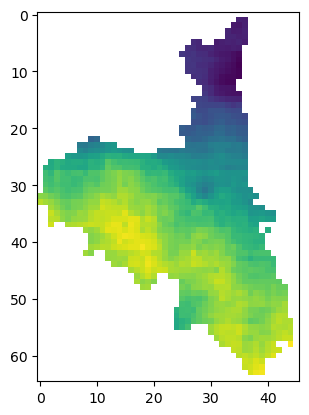

In [12]:
plt.imshow(dataset, cmap="viridis")

In [13]:
# Initialize storage for results
all_years_data = []

# Process precipitation data from 2010 to 2023
years = list(range(2010, 2024))

for year in years:
    tif_file = f"{climate_density_path}{year}R.tif"
    
    # Check if file exists
    if not os.path.exists(tif_file):
        print(f"File {tif_file} not found, skipping...")
        continue

    # Open the precipitation raster
    with rasterio.open(tif_file) as dataset:
        raster_crs = dataset.crs

        # Reproject shapefile if necessary
        if admin_gdf.crs != raster_crs:
            admin_gdf = admin_gdf.to_crs(raster_crs)

        # Process each district separately
        for idx, row in admin_gdf.iterrows():
            district_name = row["ADM3_EN"]
            district_geom = [mapping(row["geometry"])]

            try:
                # Mask the raster to extract precipitation values for the district
                out_image, _ = mask(dataset, district_geom, crop=True)
                data = out_image[0].flatten()  # Convert to 1D array

                # Remove no-data values
                data = data[data > 0]

                # Compute mean precipitation for the district
                mean_precipitation = np.mean(data)

                # Store results
                all_years_data.append({
                    "Year": year,
                    "District": district_name,
                    "Precipitation (mm)": mean_precipitation
                })

            except Exception as e:
                print(f"Error processing district {district_name} for year {year}: {e}")

# Convert to DataFrame
precipitation_df = pd.DataFrame(all_years_data)

In [14]:
precipitation_df.head(20)

,Year,District,Precipitation (mm)
0,2010,El Ghabra,433.276154
1,2010,Guerou,382.972412
2,2010,Barkeiwel,425.155334
3,2010,Legrane,441.898132
4,2010,Sani,435.842987
5,2010,Daghveg,450.473022
6,2010,Bou Lahrath,368.693787
7,2010,Hamed,422.334106
8,2010,Gueller,402.416382
9,2010,El Melgue,335.741913


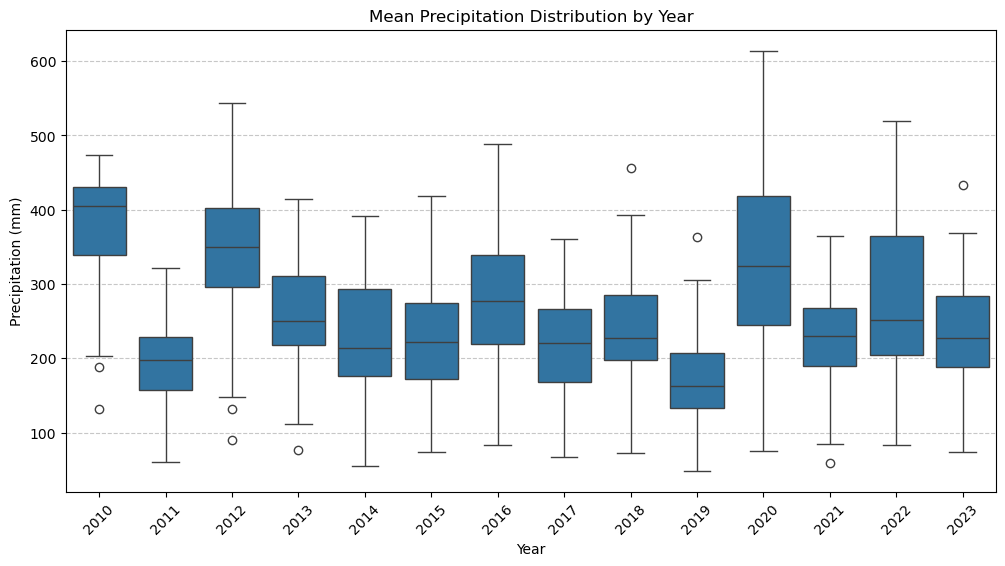

In [15]:
# plot the precipitation data
plt.figure(figsize=(12, 6))
sns.boxplot(x="Year", y="Precipitation (mm)", data=precipitation_df)
plt.title("Mean Precipitation Distribution by Year")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [16]:
# join both the district and precipitation dataframes

combined_df = district_landcover_df.merge(precipitation_df, on=["Year", "District"], how="inner")

In [17]:
combined_df.head(20)

,Year,District,LandCoverClass,PixelCount,Percentage,LandCoverLabel,Precipitation (mm)
0,2010,El Ghabra,7,19,0.727691,Open Shrublands,433.276154
1,2010,El Ghabra,10,1736,66.487936,Grasslands,433.276154
2,2010,El Ghabra,16,856,32.784374,Barren or Sparsely Vegetated,433.276154
3,2010,Guerou,10,517,94.000000,Grasslands,382.972412
4,2010,Guerou,16,33,6.000000,Barren or Sparsely Vegetated,382.972412
5,2010,Barkeiwel,7,3,0.390117,Open Shrublands,425.155334
6,2010,Barkeiwel,10,298,38.751625,Grasslands,425.155334
7,2010,Barkeiwel,16,468,60.858257,Barren or Sparsely Vegetated,425.155334
8,2010,Legrane,7,196,1.316939,Open Shrublands,441.898132
9,2010,Legrane,10,14687,98.683061,Grasslands,441.898132


## GPP Data

In [18]:
gpp_dir = "Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP/"

In [19]:
# Dictionary to store processed data
pop_5_years = []

# Process Gross Primary Production (GPP) data from 2010 to 2023
for year in years:
    pop_tif_file = f"{gpp_dir}{year}_GP.tif"  # Example: 2010GPP.tif
    
    # Check if file exists
    if not os.path.exists(pop_tif_file):
        print(f"File {pop_tif_file} not found, skipping...")
        continue

    # Open the GPP raster
    with rasterio.open(pop_tif_file) as dataset:
        raster_crs = dataset.crs

        # Reproject shapefile if necessary
        if admin_gdf.crs != raster_crs:
            admin_gdf = admin_gdf.to_crs(raster_crs)

        # Process each district separately
        for idx, row in admin_gdf.iterrows():
            district_name = row["ADM3_EN"]
            district_geom = [mapping(row["geometry"])]

            try:
                # Mask the raster to extract GPP values for the district
                out_image, _ = mask(dataset, district_geom, crop=True)
                data = out_image[0].flatten()  # Convert to 1D array

                # Remove no-data values (65533 indicates missing data)
                data = data[data < 65533]

                # Compute mean GPP for the district
                mean_gpp = np.mean(data)

                # Store results
                pop_5_years.append({
                    "Year": year,
                    "District": district_name,
                    "GPP (kg_C/m²/year)": mean_gpp
                })

            except Exception as e:
                print(f"Error processing district {district_name} for year {year}: {e}")

# Convert to DataFrame
cpp_df = pd.DataFrame(pop_5_years)

In [20]:
cpp_df.tail(25)

,Year,District,GPP (kg_C/m²/year)
339,2023,Guerou,879.609223
340,2023,Barkeiwel,586.974359
341,2023,Legrane,1158.005430
342,2023,Sani,1341.861823
343,2023,Daghveg,651.532526
344,2023,Bou Lahrath,634.255274
345,2023,Hamed,1480.328995
346,2023,Gueller,704.904713
347,2023,El Melgue,744.799031
348,2023,El Ghaira,622.460317


C:\Users\azhar\AppData\Local\Temp\ipykernel_17624\1024366951.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cpp_df, x="Year", y="GPP (kg_C/m²/year)", hue="District", palette="tab20", ci=None)


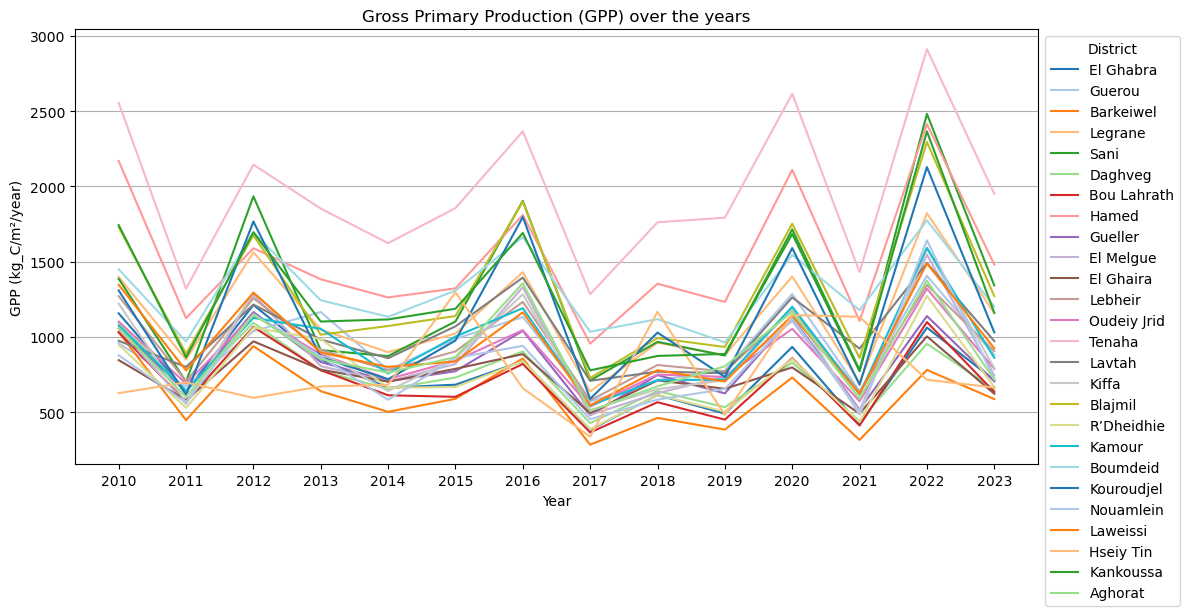

In [21]:
# plot line chart for GPP over the years

plt.figure(figsize=(12, 6))
sns.lineplot(data=cpp_df, x="Year", y="GPP (kg_C/m²/year)", hue="District", palette="tab20", ci=None)
plt.title("Gross Primary Production (GPP) over the years")
plt.ylabel("GPP (kg_C/m²/year)")
plt.xlabel("Year")
plt.xticks(years)
plt.grid(axis="y")
plt.legend(title="District", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [22]:
combined_2_df = combined_df.merge(cpp_df, on=["Year", "District"], how="inner")

In [23]:
combined_2_df.head(20)

,Year,District,LandCoverClass,PixelCount,Percentage,LandCoverLabel,Precipitation (mm),GPP (kg_C/m²/year)
0,2010,El Ghabra,7,19,0.727691,Open Shrublands,433.276154,1156.236088
1,2010,El Ghabra,10,1736,66.487936,Grasslands,433.276154,1156.236088
2,2010,El Ghabra,16,856,32.784374,Barren or Sparsely Vegetated,433.276154,1156.236088
3,2010,Guerou,10,517,94.000000,Grasslands,382.972412,957.672330
4,2010,Guerou,16,33,6.000000,Barren or Sparsely Vegetated,382.972412,957.672330
5,2010,Barkeiwel,7,3,0.390117,Open Shrublands,425.155334,1031.153846
6,2010,Barkeiwel,10,298,38.751625,Grasslands,425.155334,1031.153846
7,2010,Barkeiwel,16,468,60.858257,Barren or Sparsely Vegetated,425.155334,1031.153846
8,2010,Legrane,7,196,1.316939,Open Shrublands,441.898132,1398.148860
9,2010,Legrane,10,14687,98.683061,Grasslands,441.898132,1398.148860


In [24]:
population_path = "Datasets_Hackathon/Gridded_Population_Density_Data/Assaba_Pop_2010.tif"

with rasterio.open(population_path) as src:
    dataset = src.read(1)
    dataset_meta = src.meta
    
    nodata = src.nodata
    dataset = np.where(dataset == nodata, np.nan, dataset)




In [25]:
print(dataset)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [26]:
# Dictionary to store processed data
population_dir = "Datasets_Hackathon/Gridded_Population_Density_Data/"
years = [2010, 2015, 2020]
pop_5_years = []

# Process Population Density Data
for year in years:
    pop_tif_file = f"{population_dir}Assaba_Pop_{year}.tif"  # Example file: Assaba_Pop_2010.tif
    
    # Check if file exists
    if not os.path.exists(pop_tif_file):
        print(f"File {pop_tif_file} not found, skipping...")
        continue

    # Open the population density raster
    with rasterio.open(pop_tif_file) as dataset:
        raster_crs = dataset.crs
        nodata_value = dataset.nodata  # Get no-data value
        resolution_x, resolution_y = dataset.res  # Get pixel resolution

        # Compute the area per pixel (convert from m² to km²)
        pixel_area_km2 = (resolution_x * resolution_y) / 1e6

        # Reproject shapefile if necessary
        if admin_gdf.crs != raster_crs:
            admin_gdf = admin_gdf.to_crs(raster_crs)

        # Process each district separately
        for idx, row in admin_gdf.iterrows():
            district_name = row["ADM3_EN"]
            district_geom = [mapping(row["geometry"])]

            try:
                # Mask the raster to extract population density values for the district
                out_image, _ = mask(dataset, district_geom, crop=True)
                data = out_image[0].flatten()  # Convert to 1D array

                # Replace no-data values with NaN
                data = np.where(data == nodata_value, np.nan, data)

                # Compute mean population density (people/km²) per district
                mean_pop_density = np.nanmean(data)

                # Store results
                pop_5_years.append({
                    "Year": year,
                    "District": district_name,
                    "Population Density (People/km²)": mean_pop_density
                })

            except Exception as e:
                print(f"Error processing district {district_name} for year {year}: {e}")

# Convert to DataFrame
pop_5_years_df = pd.DataFrame(pop_5_years)

In [27]:
pop_5_years_df.head(20)

,Year,District,Population Density (People/km²)
0,2010,El Ghabra,25.989079
1,2010,Guerou,139.183945
2,2010,Barkeiwel,48.570004
3,2010,Legrane,3.990735
4,2010,Sani,6.400814
5,2010,Daghveg,15.053497
6,2010,Bou Lahrath,6.978767
7,2010,Hamed,10.279619
8,2010,Gueller,4.968314
9,2010,El Melgue,4.633765


In [28]:
year_interpolate = list(range(2010, 2024))

pop_interpolated = pop_5_years_df.pivot(index="Year", columns="District", values="Population Density (People/km²)")
pop_interpolated = pop_interpolated.reindex(year_interpolate).interpolate(method="linear", axis=0)
pop_interpolated = pop_interpolated.interpolate(method="linear", axis=0)

# Convert back to long format
pop_interpolated_df = pop_interpolated.reset_index().melt(id_vars=["Year"], var_name="District", value_name="Population Density (People/km²)")

In [29]:
pop_interpolated_df.head(20)

,Year,District,Population Density (People/km²)
0,2010,Aghorat,11.537289
1,2011,Aghorat,11.797093
2,2012,Aghorat,12.056898
3,2013,Aghorat,12.316703
4,2014,Aghorat,12.576508
5,2015,Aghorat,12.836312
6,2016,Aghorat,13.133139
7,2017,Aghorat,13.429965
8,2018,Aghorat,13.726790
9,2019,Aghorat,14.023617


C:\Users\azhar\AppData\Local\Temp\ipykernel_17624\3029393819.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=filtered_data, x="Year", y="Population Density (People/km²)", hue="District", palette="tab10", ci=None)


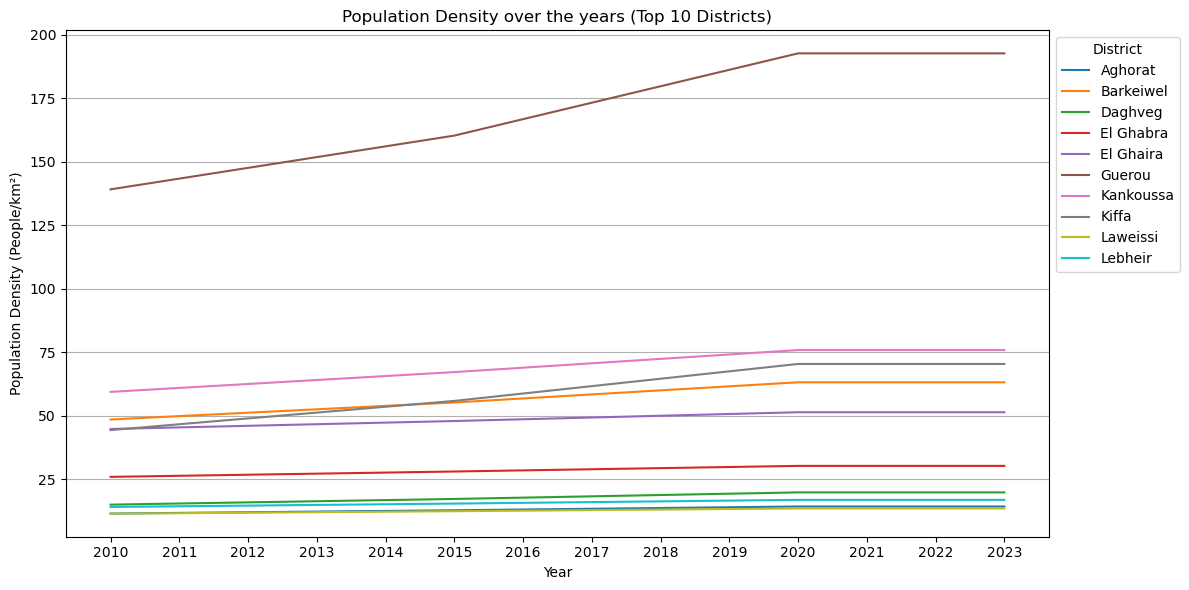

In [30]:
# Get the top 10 districts based on the maximum population density over the years
top_10_districts = pop_interpolated_df.groupby("District")["Population Density (People/km²)"].max().nlargest(10).index

# Filter the data for the top 10 districts
filtered_data = pop_interpolated_df[pop_interpolated_df["District"].isin(top_10_districts)]

# Plot the population density over the years for the top 10 districts
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="Year", y="Population Density (People/km²)", hue="District", palette="tab10", ci=None)
plt.title("Population Density over the years (Top 10 Districts)")
plt.ylabel("Population Density (People/km²)")
plt.xlabel("Year")
plt.xticks(year_interpolate)
plt.grid(axis="y")
plt.legend(title="District", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [31]:
# combine

combined_3_df = combined_2_df.merge(pop_interpolated_df, on=["Year", "District"], how="inner")

In [32]:
combined_3_df.shape

(1345, 9)

In [33]:
# export to csv

combined_3_df.to_csv("combined_data.csv", index=False)

In [34]:
combined_3_df.head(30)

,Year,District,LandCoverClass,PixelCount,Percentage,LandCoverLabel,Precipitation (mm),GPP (kg_C/m²/year),Population Density (People/km²)
0,2010,El Ghabra,7,19,0.727691,Open Shrublands,433.276154,1156.236088,25.989079
1,2010,El Ghabra,10,1736,66.487936,Grasslands,433.276154,1156.236088,25.989079
2,2010,El Ghabra,16,856,32.784374,Barren or Sparsely Vegetated,433.276154,1156.236088,25.989079
3,2010,Guerou,10,517,94.000000,Grasslands,382.972412,957.672330,139.183945
4,2010,Guerou,16,33,6.000000,Barren or Sparsely Vegetated,382.972412,957.672330,139.183945
5,2010,Barkeiwel,7,3,0.390117,Open Shrublands,425.155334,1031.153846,48.570004
6,2010,Barkeiwel,10,298,38.751625,Grasslands,425.155334,1031.153846,48.570004
7,2010,Barkeiwel,16,468,60.858257,Barren or Sparsely Vegetated,425.155334,1031.153846,48.570004
8,2010,Legrane,7,196,1.316939,Open Shrublands,441.898132,1398.148860,3.990735
9,2010,Legrane,10,14687,98.683061,Grasslands,441.898132,1398.148860,3.990735


In [35]:
combined_3_df.columns[7]

'GPP (kg_C/m²/year)'

In [36]:
# Renaming the columns with proper dictionary format
combined_3_df.rename(columns={combined_3_df.columns[8]: "PopDensity", 
                               combined_3_df.columns[7]: "GPP"}, inplace=True)


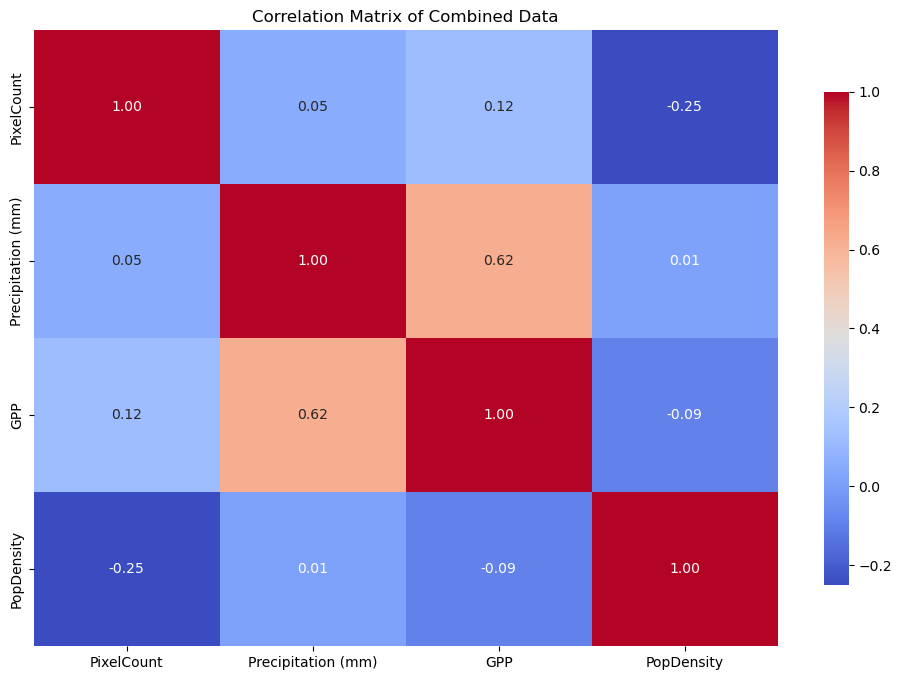

In [37]:
# make correlation matrix

corr_matrix = combined_3_df[["PixelCount", "Precipitation (mm)", "GPP", "PopDensity"]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Combined Data")

plt.show()

In [38]:
combined_3_df.isna().sum()

Year                    0
District                0
LandCoverClass          0
PixelCount              0
Percentage              0
LandCoverLabel        338
Precipitation (mm)      0
GPP                     0
PopDensity              0
dtype: int64

In [39]:
df_whole_area = combined_3_df.groupby(['Year', 'LandCoverClass', 'LandCoverLabel']).agg({
    'PixelCount': 'sum',                    # Total pixels per land cover type
    'Percentage': 'sum',                    # Total percentage per land cover type
    'Precipitation (mm)': 'sum',            # Cumulative precipitation
    'GPP': 'sum',            # Total GPP over years
    'PopDensity': 'mean',  # Average population density
}).reset_index().dropna()

In [40]:
df_whole_area['LandCoverLabel'].dropna(inplace=True)

In [41]:
df_whole_area['District'] = "Assaba"

In [42]:
df_whole_area = df_whole_area[~df_whole_area['LandCoverLabel'].str.contains('nan')]

In [43]:
df_whole_area.head(40)

,Year,LandCoverClass,LandCoverLabel,PixelCount,Percentage,Precipitation (mm),GPP,PopDensity,District
0,2010,7,Open Shrublands,2561,63.431304,9191.147461,31501.633245,14.728934,Assaba
1,2010,10,Grasslands,124305,1761.252712,9574.120117,32459.305575,19.515667,Assaba
2,2010,12,Croplands,7,0.055565,866.360840,4723.643216,7.396565,Assaba
3,2010,13,Urban and Built-up Lands,8,0.259592,896.178101,2371.625385,10.524492,Assaba
4,2010,16,Barren or Sparsely Vegetated,41332,775.000827,6604.550293,20172.536020,21.694899,Assaba
5,2011,7,Open Shrublands,3588,31.247132,4808.836914,17962.696528,15.073029,Assaba
6,2011,10,Grasslands,119917,889.514648,4992.160156,18632.215945,20.009350,Assaba
7,2011,13,Urban and Built-up Lands,8,0.143179,432.396973,1392.999545,10.792811,Assaba
8,2011,16,Barren or Sparsely Vegetated,44700,381.515355,3392.775879,13120.728869,21.348101,Assaba
9,2012,7,Open Shrublands,2648,26.362189,8626.421875,33072.771652,15.417123,Assaba


In [44]:
combined_final_df = pd.concat([combined_3_df, df_whole_area])

In [45]:
combined_final_df.sort_values(by=['LandCoverClass', 'District'], inplace=True)

In [46]:
combined_final_df = combined_final_df.reset_index(drop=True)

In [47]:
combined_final_df.head(40) 

,Year,District,LandCoverClass,PixelCount,Percentage,LandCoverLabel,Precipitation (mm),GPP,PopDensity
0,2010,Aghorat,7,136,2.051282,Open Shrublands,307.303894,1057.805551,11.537289
1,2011,Aghorat,7,168,0.866739,Open Shrublands,183.250916,600.839787,11.797093
2,2012,Aghorat,7,130,0.670691,Open Shrublands,294.590271,1148.920891,12.056898
3,2013,Aghorat,7,151,0.779033,Open Shrublands,223.234467,852.398537,12.316703
4,2014,Aghorat,7,106,0.546871,Open Shrublands,191.022980,762.225361,12.576508
5,2015,Aghorat,7,99,0.510757,Open Shrublands,230.879364,865.736413,12.836312
6,2016,Aghorat,7,91,0.469484,Open Shrublands,272.003082,1356.479309,13.133139
7,2017,Aghorat,7,57,0.294072,Open Shrublands,213.040131,508.619578,13.429965
8,2018,Aghorat,7,32,0.165093,Open Shrublands,218.973801,671.471331,13.726790
9,2019,Aghorat,7,22,0.113502,Open Shrublands,162.617889,804.706166,14.023617


In [54]:
combined_final_df.dropna(inplace=True)

In [56]:
# export csv

combined_final_df.to_csv("combined_data_final.csv", index=False)

In [57]:
import csv
import json
from collections import defaultdict

In [58]:
grouped_data = {district: group.to_dict(orient="records")
                for district, group in combined_final_df.groupby("District")}

# Export the resulting dictionary to a JSON file
output_json_path = "combined_final.json"
with open(output_json_path, "w", encoding="utf-8") as f:
    json.dump(grouped_data, f, indent=4)

# Land Degradation Rate